In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
%matplotlib inline

## Prep. Sagittal data

In [3]:
ordered_verts = ['T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4']

In [4]:
sag_path = '/home/donal/PhD/initial_spines/CT_models/data/all_verts/'

In [5]:
data_list_dir = '/home/donal/PhD/initial_spines/CT_models/data_lists/'
data_lists = []
for file in os.listdir(data_list_dir):
    if '_q' in file:
        print(file)
        data_lists.append(data_list_dir + file)
print(data_lists)

data_list_q2.txt
data_list_q4.txt
data_list_q1.txt
data_list_q3.txt
['/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q2.txt', '/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q4.txt', '/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q1.txt', '/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q3.txt']


In [19]:
def get_mask(pts_file):
    #Get vert. body annotations
    with open(pts_file, 'r') as f:
        text = f.readlines()
        lines = [line.strip() for line in text]
        start = lines.index('{')
        end = lines.index('}')
        x = [float(x.split(' ')[0]) for x in lines[start+1:end]]
        y = [float(x.split(' ')[1]) for x in lines[start+1:end]]
        points = (x, y)
    return points

def get_id(data_list):
    """
    Collect paths to point files, in a dict
    """
    sag_files = [file for file in os.listdir(sag_path)]
    pts_files = {}
    with open(data_list, 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
        for line in lines:
            pts, img = line.split(':')
            id_ = pts.split('.')[0]
            vert_list = list(filter(lambda x: f'{id_}' in x, sag_files))
            volume_name = id_.split('_midline')[0] + '.nii'
            pts_files[volume_name] = vert_list
    return pts_files

def get_points(pts_files):
    """
     Get + organise annotations
    """
    mask_dict = {} #All landmark annotations for making a mask of vert.
    for key, val in pts_files.items():
        name = f"{key.split('.')[0]}"
        mask_dict[name] = {}
        for elem in val:
            # Iterate over available vert. annotations
            # Find name of vertebra
            name_split = re.findall('[0-9a-zA-Z][^A-Z]*',
                                    os.path.splitext(elem)[0])
            vert = name_split[-1].split('_')[0]
            # Get all landmark point annotations
            points = get_mask(os.path.join(sag_path, elem))
            mask_dict[name][vert] = points
    return mask_dict


def split_volumes(pts_files, fold):
    root_dir = '/data/PAB_data/ct_volumes/'
    out_dir = f'/data/PAB_data/volume_folds/{fold}/'
    os.makedirs(out_dir, exist_ok=True)
    print('Organising volumes')
    for name in pts_files.keys():
        shutil.copyfile(root_dir + name, out_dir + name)


In [20]:
fold_data = {}
for data_list in data_lists:
    print(data_list)
    num = data_list.split('/')[-1].split('.')[0].split('_')[-1]
    pts_files = get_id(data_list)
    print('FOLD:', num)
    #split_volumes(pts_files, num)
    
    print(f'Found {len(list(pts_files.keys()))} points files')
    mask_dict = get_points(pts_files)
    print(f'Found {len(list(mask_dict.keys()))} patients w. full vert. annotations.')
    fold_data[num] = mask_dict

/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q2.txt
FOLD: q2
Found 87 points files
Found 87 patients w. full vert. annotations.
/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q4.txt
FOLD: q4
Found 102 points files
Found 102 patients w. full vert. annotations.
/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q1.txt
FOLD: q1
Found 100 points files
Found 100 patients w. full vert. annotations.
/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q3.txt
FOLD: q3
Found 86 points files
Found 86 patients w. full vert. annotations.


## Organise input data

In [22]:
from PIL import Image

q2
1.0 1.0 1.0


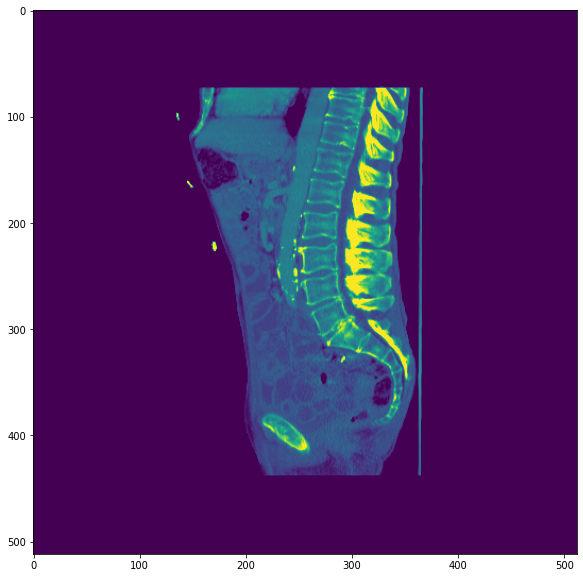

In [35]:
for fold, mask_dict in fold_data.items():
    print(fold)
    for name in mask_dict.keys():
        projections = np.load(f'../images_sagittal/all_projections/{name}.npy')
        midline = np.load(f'/data/PAB_data/images_sagittal/sagittal_midline/{fold}/{name}.npy').astype(np.float32)
        midline /= 255
        mip = projections[...,0]
        avg = projections[..., 1]
        print(mip.max(), avg.max(), midline.max())
        composite = np.stack([mip, avg, midline], axis=-1)
        plt.figure(figsize=(10,10))
        plt.imshow(composite[...,2])
        break
    break

In [10]:
from sklearn.preprocessing import LabelBinarizer

In [52]:
def filter_masks(mask_dict, cor_points='../formatted_pts.csv', cor_dir='../data/parent_data/coronal_midline/mips/'):
    # Remove files that don't have matching coronal midline annotations
    # Since we can't extract sagittal midline
    df = pd.read_csv(cor_points, index_col=0, header=0)
    coronal_files = [file.split('.')[0] for file in os.listdir(cor_dir)]
    files = [file for file in df.index if file.replace('_kj', '') in coronal_files]
    print(len(files))
    out_dict = {key: val for key}
    

In [53]:
vert_list = []
# Convert vertebra names to one-hot
for val in mask_dict.values():
    vert_list.extend(list(val.keys()))
all_verts = list(np.unique(vert_list))
enc = LabelBinarizer()
enc.fit(all_verts)
enc.classes_ = ordered_verts
# Remove files that don't have corresponding midline annotations
filter_masks(mask_dict)

300
